In [2]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('../')

import warnings
warnings.filterwarnings('ignore')

from process.config import *
from process.measurements import *
from models.smooth import *


In [10]:
index_year = 2016
day_gap = 0
min_pre_tests = 5
percent_cutoff = 0.80

measurements = pd.read_csv('../data/processed/lab_measurements.csv')[['subject_id', 'time', 'test_name', 'numeric_value', 'gender_concept_id', 'age']].sort_values(by=['subject_id', 'test_name', 'time'])
measurements['sex'] = measurements['gender_concept_id'].map(lambda x: 'M' if x == 0 else 'F')

# Process with both filtering methods
#processed_df_filter = filter_measurements_df(measurements, index_year=index_year, day_gap=day_gap, min_pre_tests=min_pre_tests)
processed_df_cutoff = cutoff_measurements_df(measurements, percent=percent_cutoff, min_tests=min_pre_tests)

# Use the cutoff version
processed_df = processed_df_cutoff
display(processed_df.head())

Filtering Sequences: 100%|██████████| 13790/13790 [00:11<00:00, 1214.90it/s]


,subject_id,time,test_name,numeric_value,gender_concept_id,age,sex
842156,115967103,2012-08-01 12:23:00,HCT,24.1,1,45.363450,F
842165,115967103,2012-08-09 13:10:00,HCT,30.6,1,45.385352,F
842174,115967103,2012-08-12 16:10:00,HCT,28.0,1,45.393566,F
842183,115967103,2012-08-14 12:00:00,HCT,25.3,1,45.399042,F
842192,115967103,2012-08-24 07:25:00,HCT,25.0,1,45.426420,F


In [12]:
def process_all_pairs(measurements_df):
    df = measurements_df.copy()
    df['time'] = pd.to_datetime(df['time'])
    
    grouped = df.groupby(['subject_id', 'test_name'])
    
    results = []
    for (subject_id, test_name), group in grouped:
        myseq = group[['time', 'numeric_value']].drop_duplicates()
        myseq = myseq.set_index('time').sort_index()
        
        curve, mean, std = lowess_smooth(myseq, frac=0.3)
        
        results.append({
            'subject_id': subject_id,
            'test_name': test_name,
            'smoothed_curve': curve,
            'smoothed_mean': mean,
            'smoothed_var': std**2
        })
        
    return pd.DataFrame(results)

# Process all pairs
results = process_all_pairs(processed_df)
display(results)



,subject_id,test_name,smoothed_curve,smoothed_mean,smoothed_var
0,115967103,HCT,"[25.32821374233798, 25.96082910999504, 26.2311...",30.871432,12.615627
1,115967103,HGB,"[8.175264566814908, 8.517707814890334, 8.65560...",10.476724,1.324179
2,115967103,MCH,"[30.459000369026267, 30.469411786579023, 30.47...",31.684500,0.473306
3,115967103,MCHC,"[33.119685440122616, 33.46567923172328, 33.590...",34.253237,0.321235
4,115967103,MCV,"[91.78492433152803, 91.35710358463103, 91.1946...",91.874309,6.743571
...,...,...,...,...,...
13275,115973826,MCV,"[84.65627405139274, 84.37649767133372, 84.3758...",87.488864,4.117501
13276,115973826,PLT,"[264.3725834170722, 261.7732631257859, 261.768...",161.088505,3278.560841
13277,115973826,RBC,"[5.073447245238077, 5.080098967566683, 5.08009...",4.305586,0.162358
13278,115973826,RDW,"[16.477734063812754, 16.012034480076192, 16.01...",20.386170,7.100676


In [5]:
def plot_series_with_toggle(ax, series_dict):
    """Plot all series and make legend items toggleable."""
    lines = []
    for label, series in series_dict.items():
        if label == "Original":
            line, = ax.plot(series.index, series.values, 'o', label=label, markersize=4)
        else:
            line, = ax.plot(series, label=label)
        lines.append(line)

    legend = ax.legend(loc="upper left")
    for legline in legend.get_lines():
        legline.set_picker(5)

    line_map = dict(zip(legend.get_lines(), lines))

    def on_pick(event):
        legline = event.artist
        origline = line_map[legline]
        vis = not origline.get_visible()
        origline.set_visible(vis)
        legline.set_alpha(1.0 if vis else 0.2)
        ax.figure.canvas.draw()

    ax.figure.canvas.mpl_connect('pick_event', on_pick)


In [13]:
results

,subject_id,test_name,smoothed_curve,smoothed_mean,smoothed_var
0,115967103,HCT,"[25.32821374233798, 25.96082910999504, 26.2311...",30.871432,12.615627
1,115967103,HGB,"[8.175264566814908, 8.517707814890334, 8.65560...",10.476724,1.324179
2,115967103,MCH,"[30.459000369026267, 30.469411786579023, 30.47...",31.684500,0.473306
3,115967103,MCHC,"[33.119685440122616, 33.46567923172328, 33.590...",34.253237,0.321235
4,115967103,MCV,"[91.78492433152803, 91.35710358463103, 91.1946...",91.874309,6.743571
...,...,...,...,...,...
13275,115973826,MCV,"[84.65627405139274, 84.37649767133372, 84.3758...",87.488864,4.117501
13276,115973826,PLT,"[264.3725834170722, 261.7732631257859, 261.768...",161.088505,3278.560841
13277,115973826,RBC,"[5.073447245238077, 5.080098967566683, 5.08009...",4.305586,0.162358
13278,115973826,RDW,"[16.477734063812754, 16.012034480076192, 16.01...",20.386170,7.100676


In [111]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF
from sklearn.preprocessing import StandardScaler
from statsmodels.tsa.statespace.structural import UnobservedComponents

def gaussian_process_smooth(seq, length_scale=30.0):
    # Convert timestamps to days since first timestamp
    time_in_days = (seq.index - seq.index[0]).total_seconds() / (24 * 3600)
    time_in_days = time_in_days.values.reshape(-1, 1)
    
    #X_scaled = StandardScaler().fit_transform(time_in_days)
    X_scaled = time_in_days
    y = seq.values

    gp = GaussianProcessRegressor(kernel=RBF(length_scale=length_scale))
    gp.fit(X_scaled, y)
    y_pred, y_std = gp.predict(X_scaled, return_std=True)
    
    # Return predictions with original index
    return pd.Series(y_pred, index=seq.index), pd.Series(y_std, index=seq.index)
def kalman_smooth(seq, length_scale=30.0):
    seq = seq.sort_index()

    # Resample to 90 day intervals to create regular time steps
    seq_daily = seq.resample(f'{length_scale}D').mean().interpolate('time')

    #  Fit Kalman Filter (Local Level Model)
    model = UnobservedComponents(seq_daily['numeric_value'], level='local level')
    result = model.fit(disp=False)

    seq_daily['smoothed'] = result.smoothed_state[0]
    mean = np.mean(seq_daily['smoothed'])    
    std = np.std(seq_daily['numeric_value'])
    
    return seq_daily['smoothed'], mean, std

import numpy as np
import pandas as pd

def kalman_filter(
    series: pd.Series,
    x0: float = 8.0,          # prior level (your belief)
    P0: float = 1.0,          # prior uncertainty
    Q: float = 0.01,          # process noise (model uncertainty)
    R: float = 0.25           # measurement noise (sensor uncertainty)
) -> pd.Series:
    
    x = np.array([[x0]])     # initial state
    P = np.array([[P0]])     # initial covariance
    F = np.array([[1]])      # state transition matrix
    H = np.array([[1]])      # measurement function
    Q = np.array([[Q]])      # process noise
    R = np.array([[R]])      # measurement noise

    filtered = []
    for z in series.values:
        # Predict
        x = F @ x
        P = F @ P @ F.T + Q

        # Update
        y = np.array([[z]]) - H @ x
        S = H @ P @ H.T + R
        K = P @ H.T @ np.linalg.inv(S)
        x = x + K @ y
        P = (np.eye(len(K)) - K @ H) @ P

        filtered.append(x[0, 0])

    mean = np.mean(filtered)    
    std = np.std(filtered)
    return pd.Series(filtered, index=series.index, name='filtered'), mean, std


In [134]:
subject_id

array([115967103, 115967114, 115967124, ..., 115973821, 115973825,
       115973826], shape=(1472,))

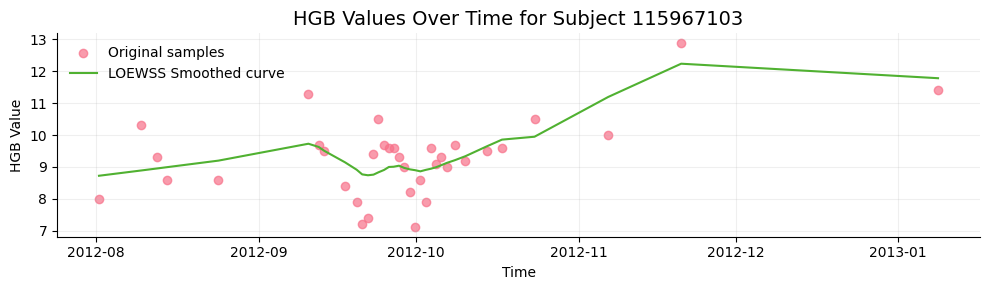

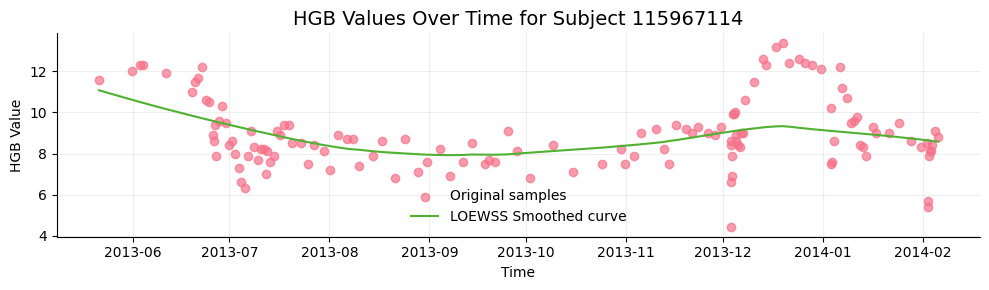

In [142]:
import seaborn as sns

# Get sample data for one subject
subject_id = results.query('test_name == "HGB"')['subject_id'].unique()

for subject in subject_id[:2]:
    sample = processed_df.query('test_name == "HGB" and subject_id == @subject')    
    seq = sample[['time', 'numeric_value']].drop_duplicates().set_index('time').sort_index()
    curve, mean, std, x_mean, x_std = lowess_smooth(seq, frac=0.5)
    
    # new_curve = gaussian_kernel_smooth(seq, window_days=90, std_days=15)
    #new_curve = gaussian_process_smooth(seq, length_scale=1.0)
    #new_curve = gaussian_process_smooth(seq, length_scale=1.0)
    # # Get smoothed curve for this subject
    # smoothed = results.query('test_name == "HGB" and subject_id == @subject')['smoothed_curve'].iloc[0]
    
    
    # Create figure and axis
    fig, ax = plt.subplots(figsize=(10, 3))

    # Plot layers
    colors = sns.color_palette("husl", 3)
    ax.scatter(sample['time'], sample['numeric_value'], color=colors[0], label='Original samples', alpha=0.7)
    ax.plot(sample['time'].iloc[0:len(curve)], curve, color=colors[1], label='LOEWSS Smoothed curve')
   #ax.plot(new_curve[0].index.tolist(), new_curve[0].values.tolist(), color=colors[2], label='Kalman Smoothed curve')
    
    # Labels & Theme
    ax.set_title(f'HGB Values Over Time for Subject {subject}', fontsize=14)
    ax.set_xlabel('Time')
    ax.set_ylabel('HGB Value')
    ax.grid(True, alpha=0.2)
    ax.legend(loc='best', frameon=False)
    sns.despine()

    plt.tight_layout()
    plt.show()

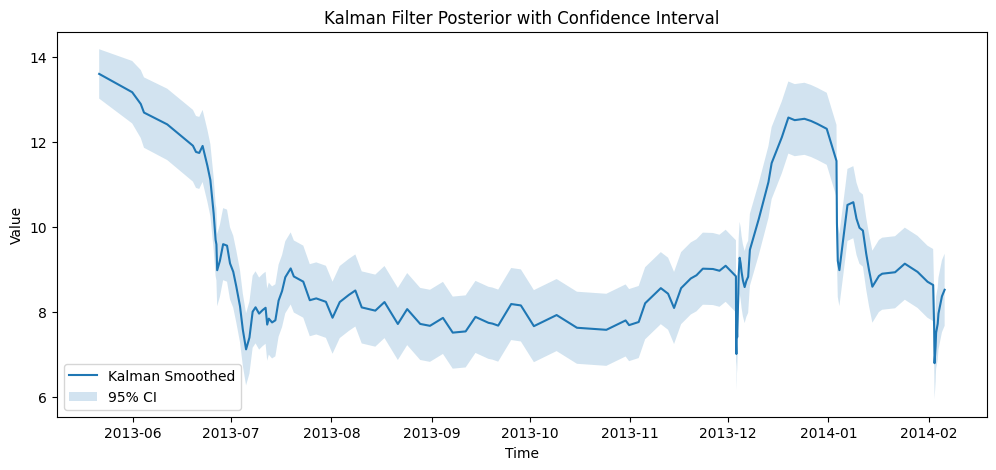

In [139]:
def kalman_filter_mean_std(
    series: pd.Series,
    x0: float = 8.0, # prior level
    P0: float = 1.0, # prior uncertainty
    Q: float = 0.1, # process noise
    R: float = 0.5 # measurement noise
) -> pd.DataFrame:
    """
    Applies 1D Kalman filter and returns posterior mean and std deviation at each step.
    """
    x = np.array([[x0]])
    P = np.array([[P0]])
    F = np.array([[1]])
    H = np.array([[1]])
    Q = np.array([[Q]])
    R = np.array([[R]])

    means = []
    stds = []

    for z in series.values:
        # Predict
        x = F @ x
        P = F @ P @ F.T + Q

        # Update
        y = np.array([[z]]) - H @ x
        S = H @ P @ H.T + R
        K = P @ H.T @ np.linalg.inv(S)
        x = x + K @ y
        P = (np.eye(len(K)) - K @ H) @ P

        means.append(x[0, 0][0])
        stds.append(np.sqrt(P[0, 0]))

    return pd.DataFrame({
        "posterior_mean": means,
        "posterior_std": stds
    }, index=series.index)

result = kalman_filter_mean_std(seq, 14, 0.001)
result.index = pd.to_datetime(result.index)
#result['posterior_mean'] = pd.to_numeric(result['posterior_mean'], errors='coerce')
#result['posterior_std'] = pd.to_numeric(result['posterior_std'], errors='coerce')

import matplotlib.pyplot as plt

mean = result['posterior_mean']
std = result['posterior_std']
ci_upper = mean + 2 * std
ci_lower = mean - 2 * std

plt.figure(figsize=(12, 5))
plt.plot(result.index, mean, label='Kalman Smoothed')
plt.fill_between(result.index, ci_lower, ci_upper, alpha=0.2, label='95% CI')
plt.legend()
plt.title('Kalman Filter Posterior with Confidence Interval')
plt.xlabel('Time')
plt.ylabel('Value')
plt.show()


In [133]:
seq

,numeric_value
time,
2013-05-21 12:12:00,11.6
2013-05-31 16:05:00,12.0
2013-06-03 07:25:00,12.3
2013-06-04 07:20:00,12.3
2013-06-11 10:52:00,11.9
...,...
2014-02-03 03:30:00,8.1
2014-02-03 15:15:00,8.1
2014-02-03 20:55:00,8.4


In [42]:
len(new_curve[0].index)

35